In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# for visualization on GitHub, comment to use interactively
import plotly.io as pio
pio.renderers.default = 'png'

In [3]:
import tensorflow as tf
import numpy as np
import pickle
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as colors
import plotly.graph_objects as go
from pprint import pprint
from absl import flags
import config_flags

# Loading data

In [4]:
RES_DIR = 'results/loss_configurations_search/'

In [5]:
def list_final_dirs(directory):
    results_paths = []
    for root, dirs, files in os.walk(directory):
        for f in files:
            if "flags.txt" in f:
                results_paths.append(os.path.join(root, f))
    return results_paths

In [6]:
flagfiles = list_final_dirs(RES_DIR)
print("\n".join(flagfiles[:5]))
print(len(flagfiles))

results/loss_configurations_search/without_bn/without_act/std_exp-0.2/without_corr/hard_loss/run_3_flags.txt
results/loss_configurations_search/without_bn/without_act/std_exp-0.2/without_corr/hard_loss/run_2_flags.txt
results/loss_configurations_search/without_bn/without_act/std_exp-0.2/without_corr/hard_loss/run_1_flags.txt
results/loss_configurations_search/without_bn/without_act/std_exp-0.2/without_corr/hard_loss/run_4_flags.txt
results/loss_configurations_search/without_bn/without_act/std_exp-0.2/without_corr/hard_loss/run_0_flags.txt
600


In [7]:
def extract_results(flagfile):
    config_flags.load_flags(flagfile)
    run_flags = flags.FLAGS
    
    history_path = os.path.join(
        run_flags.save_path, 
        run_flags.prefix) + "history.pkl"
    
    try :
        with open(history_path, 'rb') as f:
            history = pickle.load(f)
    except:
        print(f"Run {flagfile} has no history.pkl, potentially crashed.")
        return None
        
    return history
    
    # mocking function
    # return {
    #     "hypersphere_percentage": np.random.uniform(0, 1),
    #     "val_accuracy": np.random.uniform(0, 1),
    #     "val_loss": np.random.uniform(0, 1),
    #     "val_max_val_auroc": np.random.uniform(0, 1),
    #     "val_real_auroc": np.random.uniform(0, 1),
    #     "std_cls_0": np.random.normal(0, 1),
    #     "std_cls_1": np.random.normal(0, 1),
    #     "mean_weights_corr": np.random.uniform(0, 0.2),
    #     "mean_weights_std": np.random.uniform(0, 0.2),
    # }


## Group runs with same parameters

In [8]:
repetition_dict = {}
for file in flagfiles:
    config = file.rsplit('/', 1)[0].replace(RES_DIR, '')
    
    results = extract_results(file)
    if results is None:
        continue
    
    if config not in repetition_dict:
        repetition_dict[config] = {}
        for k in results:
            repetition_dict[config][k] = []
            
    for k, v in results.items():
        repetition_dict[config][k].append(v)


Run results/loss_configurations_search/without_bn/with_act_leaky/without_std/without_corr/smooth_loss/run_2_flags.txt has no history.pkl, potentially crashed.
Run results/loss_configurations_search/without_bn/with_act_leaky/without_std/with_corr/smooth_loss/run_4_flags.txt has no history.pkl, potentially crashed.
Run results/loss_configurations_search/without_bn/with_act_leaky/std_linear-0.1/with_corr/hard_loss/run_0_flags.txt has no history.pkl, potentially crashed.
Run results/loss_configurations_search/with_bn/with_act_leaky/without_std/without_corr/hard_loss/run_3_flags.txt has no history.pkl, potentially crashed.
Run results/loss_configurations_search/with_bn/with_act_leaky/std_exp-0.1/without_corr/hard_loss/run_3_flags.txt has no history.pkl, potentially crashed.
Run results/loss_configurations_search/with_bn/with_act_leaky/std_linear-0.2/with_corr/smooth_loss/run_4_flags.txt has no history.pkl, potentially crashed.
Run results/loss_configurations_search/with_bn/with_act_leaky/st

In [9]:
repetition_dict.keys()

dict_keys(['without_bn/without_act/std_exp-0.2/without_corr/hard_loss', 'without_bn/without_act/std_exp-0.2/without_corr/smooth_loss', 'without_bn/without_act/std_exp-0.2/with_corr/hard_loss', 'without_bn/without_act/std_exp-0.2/with_corr/smooth_loss', 'without_bn/without_act/without_std/without_corr/hard_loss', 'without_bn/without_act/without_std/without_corr/smooth_loss', 'without_bn/without_act/without_std/with_corr/hard_loss', 'without_bn/without_act/without_std/with_corr/smooth_loss', 'without_bn/without_act/std_exp-0.1/without_corr/hard_loss', 'without_bn/without_act/std_exp-0.1/without_corr/smooth_loss', 'without_bn/without_act/std_exp-0.1/with_corr/hard_loss', 'without_bn/without_act/std_exp-0.1/with_corr/smooth_loss', 'without_bn/without_act/std_linear-0.2/without_corr/hard_loss', 'without_bn/without_act/std_linear-0.2/without_corr/smooth_loss', 'without_bn/without_act/std_linear-0.2/with_corr/hard_loss', 'without_bn/without_act/std_linear-0.2/with_corr/smooth_loss', 'without_

## Compute mean and std for each parameter set

In [10]:
results_dict = {}
for config, results in repetition_dict.items():
    results_dict[config] = {}
    # for k, v in results.items():
    #     results_dict[config][k] = {
    #         "mean": np.mean(v),
    #         "std": np.std(v),
    #     }
    for k, v in results.items():
        results_dict[config][(k, "mean")] = np.mean(v, axis=0)[-1]
        results_dict[config][(k, "std")] = np.std(v, axis=0)[-1]
        
        if k == "mean_weights_std":
            results_dict[config][(k, "mean")] = np.mean(v)
            results_dict[config][(k, "std")] = np.std(v)

In [11]:
# split config in multiple columns
final_dict = {}
index_2_params = {}
columns = ["Using BatchNorm", "Activation", "Std penalty", "Correlation penalty", "Loss"]
# columns = ["Activation", "Std penalty", "Correlation penalty", "Loss"]

final_dict[("idx", "")] = []
for i in columns:
    final_dict[(i, '')] = []

for idx, (config, results) in enumerate(results_dict.items()):
    index_2_params[idx] = config
    params = config.split('/')
    converted_params = []
    converted_params.append("Yes" if "without" not in params[0] else "No")
    converted_params.append({"with_act": "ReLU", "without_act": "None", "with_act_leaky": "LeakyReLU"}[params[1]])
    converted_params.append("No std" if "without" in params[2] else params[2])
    converted_params.append("Yes" if "without" not in params[3] else "No")
    converted_params.append(params[4].split('_')[0])
    
    final_dict[("idx", "")].append(idx)
    
    for i, p in enumerate(converted_params):
        final_dict[(columns[i], '')].append(p)
    
    for k, v in results.items():
        final_dict.setdefault(k, []).append(v)
    

# Results in DataFrame

In [12]:
# sort dataframe by val_accuracy
df = pd.DataFrame(final_dict).set_index("idx")
df = df.sort_values(by=[("val_accuracy", "mean")], ascending=False)
df.head()

Using BatchNorm Activation  Std penalty Correlation penalty    Loss  \
                                                                          
idx                                                                       
29               No       ReLU  std_exp-0.1                  No  smooth   
89              Yes       ReLU  std_exp-0.1                  No  smooth   
41               No  LeakyReLU  std_exp-0.2                  No  smooth   
101             Yes  LeakyReLU  std_exp-0.2                  No  smooth   
85              Yes       ReLU       No std                  No  smooth   

     accuracy           val_accuracy           test_accuracy  ... test_loss  \
         mean       std         mean       std          mean  ...      mean   
idx                                                           ...             
29   0.926167  0.001016     0.931300  0.001945       0.92975  ...  0.483395   
89   0.923617  0.000867     0.931133  0.000799       0.93035  ...  0.497316   
41   0.923908  0.001689     0.930367  0.003251       0.92875  ...  0.531599   
101  0.922617  0.001420     0.930267  0.002013       0.92630  ...  0.545263   
85   0.924617  0.001376     0.930133  0.001752       0.92980  ...  0.498820   

              test_real_auroc           test_max_val_auroc            \
          std            mean       std               mean       std   
idx                                                                    
29   0.005707       80.936636  0.306094          80.010941  0.288796   
89   0.008608       79.464879  0.422846          80.124135  0.643880   
41   0.013942       78.350093  0.344588          80.727158  0.511599   
101  0.021020       77.867210  0.495155          80.743580  0.606345   
85   0.008259       79.491681  0.497672          79.784275  0.627036   

     test_oscr           val_hypersphere_percentage            
          mean       std                       mean       std  
idx                                                            
29   78.087835  0.256922                   0.897800  0.001976  
89   76.590850  0.421218                   0.902033  0.000499  
41   75.375800  0.284172                   0.899367  0.003131  
101  74.771904  0.519571                   0.898200  0.002886  
85   76.605148  0.397663                   0.899600  0.002509  

[5 rows x 39 columns]

In [13]:
# sort dataframe by hypersphere_percentage
df = pd.DataFrame(final_dict).set_index("idx")
df = df.round(5)
df = df.sort_values(by=[("val_hypersphere_percentage", "mean")], ascending=False)
df.head()

Using BatchNorm Activation  Std penalty Correlation penalty    Loss  \
                                                                          
idx                                                                       
47               No  LeakyReLU       No std                 Yes  smooth   
107             Yes  LeakyReLU       No std                 Yes  smooth   
89              Yes       ReLU  std_exp-0.1                  No  smooth   
23               No       ReLU  std_exp-0.2                 Yes  smooth   
43               No  LeakyReLU  std_exp-0.2                 Yes  smooth   

    accuracy          val_accuracy          test_accuracy  ... test_loss  \
        mean      std         mean      std          mean  ...      mean   
idx                                                        ...             
47   0.92624  0.00142      0.92921  0.00198       0.92850  ...   0.51552   
107  0.92408  0.00084      0.92903  0.00127       0.92760  ...   0.53164   
89   0.92362  0.00087      0.93113  0.00080       0.93035  ...   0.49732   
23   0.92548  0.00114      0.92883  0.00161       0.92810  ...   0.50029   
43   0.92514  0.00133      0.92887  0.00137       0.92720  ...   0.54041   

             test_real_auroc          test_max_val_auroc          test_oscr  \
         std            mean      std               mean      std      mean   
idx                                                                           
47   0.01069        79.00312  0.48066           81.28818  0.65453  76.09213   
107  0.00689        77.67625  0.49499           79.68830  0.29477  74.76882   
89   0.00861        79.46488  0.42285           80.12414  0.64388  76.59085   
23   0.01666        80.20604  0.19884           80.35607  0.45235  77.26647   
43   0.00949        78.40822  0.38949           81.08925  0.67180  75.35986   

             val_hypersphere_percentage           
         std                       mean      std  
idx                                               
47   0.37993                    0.90221  0.00135  
107  0.47518                    0.90217  0.00085  
89   0.42122                    0.90203  0.00050  
23   0.16510                    0.90157  0.00227  
43   0.43760                    0.90097  0.00201  

[5 rows x 39 columns]

# Graphs

## Filtering results

In [14]:
# TODO: according to below results, we know that ReLU and smooth loss must 
# be used so we can remove other results to visualize better
# df = df[(df[("Activation", "")] == "ReLU") & (df[("Loss", "")] == "smooth")]

In [15]:
def scatter_results(df, x, y, x_label, y_label, title, labels_column, legend_title=None):

    fig = go.Figure()
    
    for label in df[labels_column].unique():
        class_df=df[df[labels_column] == label]
        
        # Add hover text
        hover_text = [
            f"Using BatchNorm: {bn}<br>Activation: {lr}<br>Std penalty: {std}<br>Correlation penalty: {corr}<br>Loss: {loss}"
            for bn, lr, std, corr, loss in zip(
                class_df[("Using BatchNorm", "")],
                class_df[("Activation", "")],
                class_df[("Std penalty", "")],
                class_df[("Correlation penalty", "")],
                class_df[("Loss", "")],
            )
        ]
        
        fig.add_trace(
            go.Scatter(
                x=class_df[x],
                y=class_df[y],
                mode='markers',
                marker=dict(
                    size=10,
                ),
                name=label,
                text=hover_text,
                hoverinfo="text"
            )
        )
    
    # Change legend title
    fig.update_layout(
        legend_title=legend_title,
    )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label,
    )
    
    fig.show()

## Hypersphere percentage vs Accuracy

In [16]:
np.corrcoef(
    df[('val_hypersphere_percentage', 'mean')],
    df[('val_accuracy', 'mean')]
)

array([[1.       , 0.7181633],
       [0.7181633, 1.       ]])

In [17]:
df_using_corr = df[df[("Correlation penalty", "")] == "Yes"]
df_without_corr = df[df[("Correlation penalty", "")] == "No"]

# print variances
print(df_using_corr[('val_accuracy', 'std')].std())
print(df_without_corr[('val_accuracy', 'std')].std())

# look for significant difference
from scipy.stats import ttest_ind

ttest_ind(
    df_without_corr[('val_accuracy', 'mean')],
    df_using_corr[('val_accuracy', 'mean')],
    equal_var=False
)

0.00055492745
0.0006823633


TtestResult(statistic=1.6638542072303453, pvalue=0.09887339459643636, df=114.61628880565173)

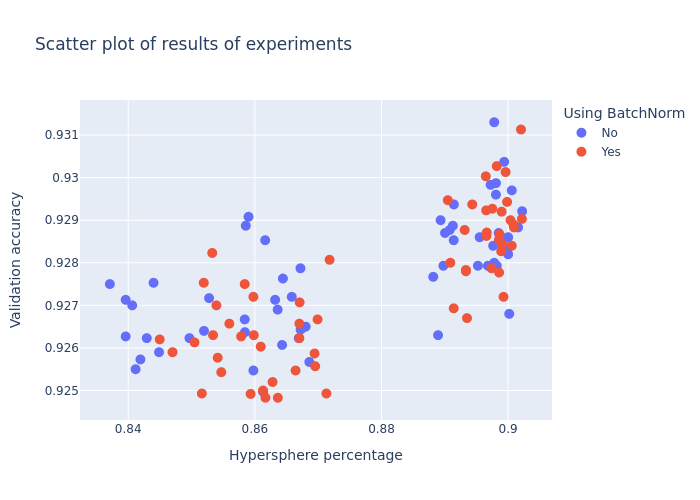

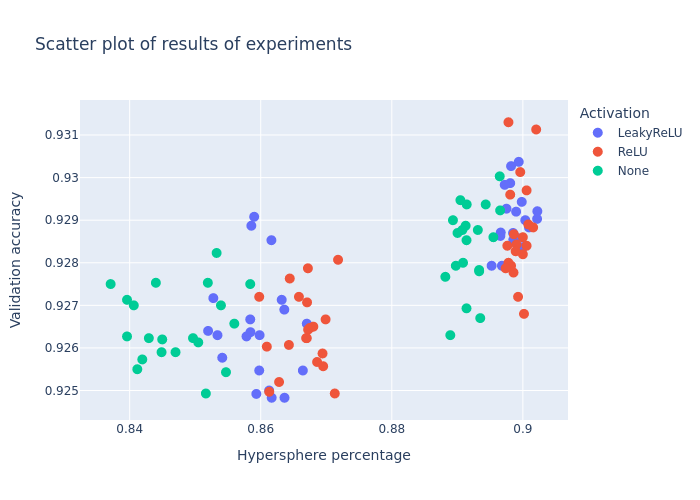

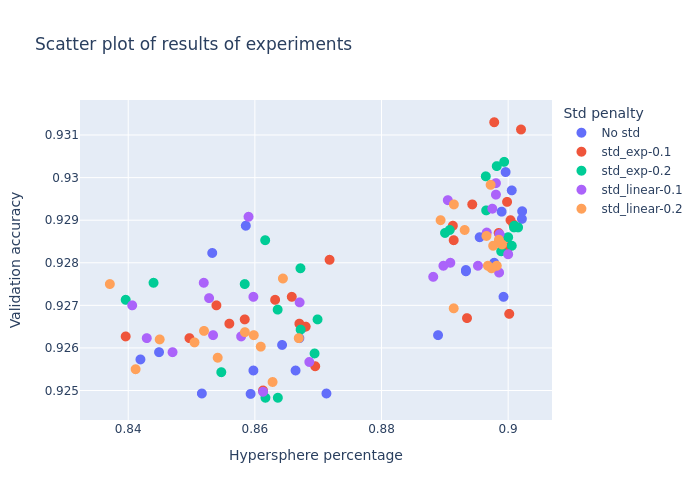

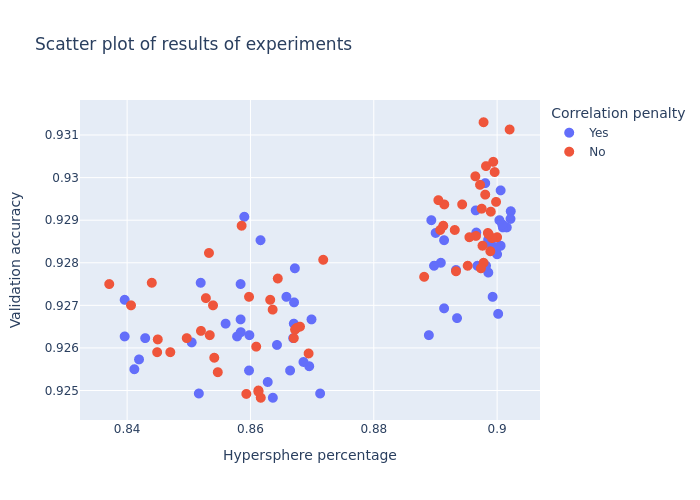

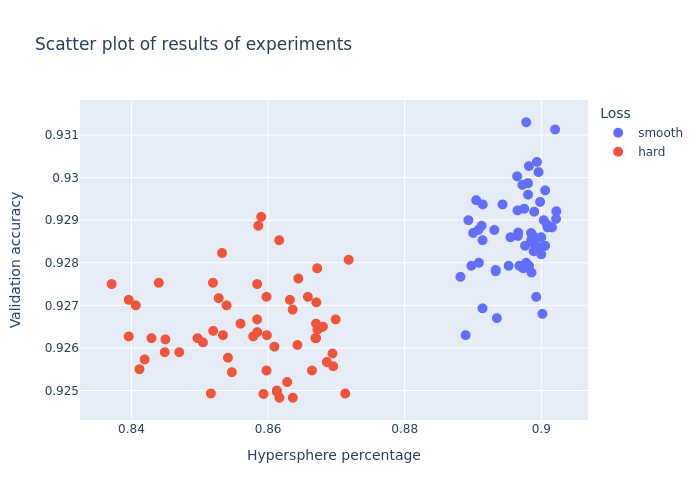

In [18]:
for labels_columns in df.columns[:5]:
    scatter_results(
        df,
        x=('val_hypersphere_percentage', 'mean'),
        y=('val_accuracy', 'mean'),
        x_label='Hypersphere percentage',
        y_label='Validation accuracy',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

## Hypersphere percentage vs Real AUROC

In [19]:
np.corrcoef(
    df[('val_hypersphere_percentage', 'mean')],
    df[('val_real_auroc', 'mean')],
)

array([[1.        , 0.85705131],
       [0.85705131, 1.        ]])

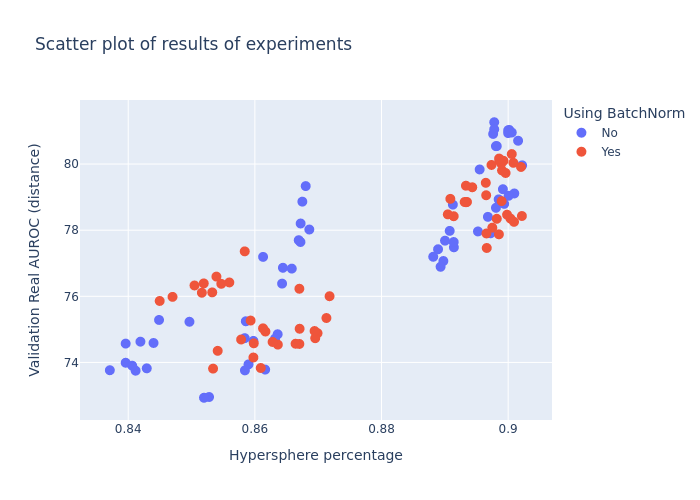

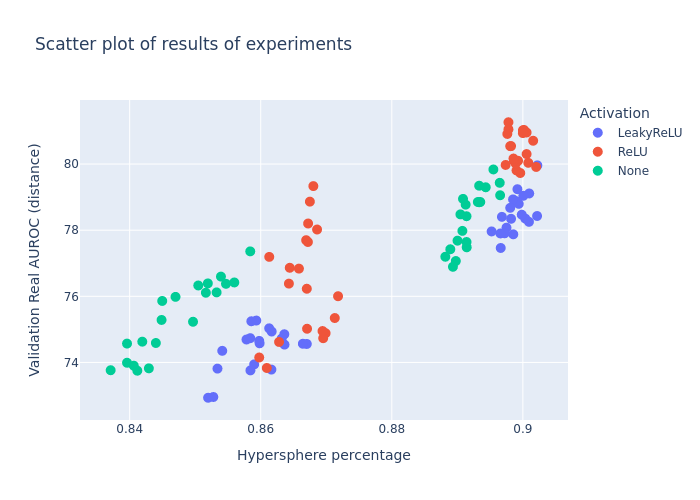

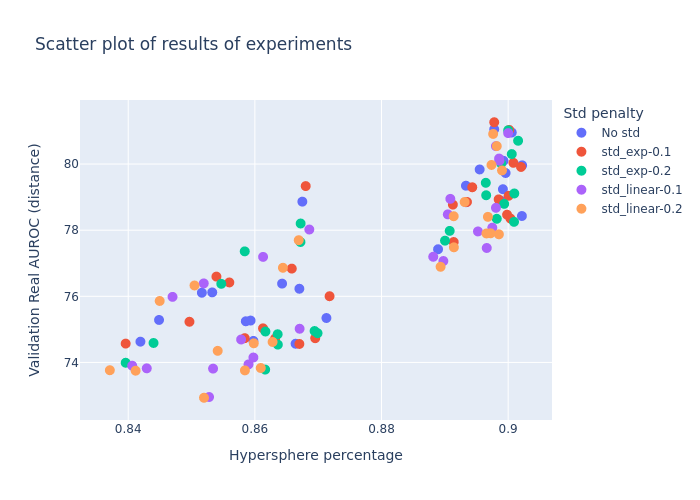

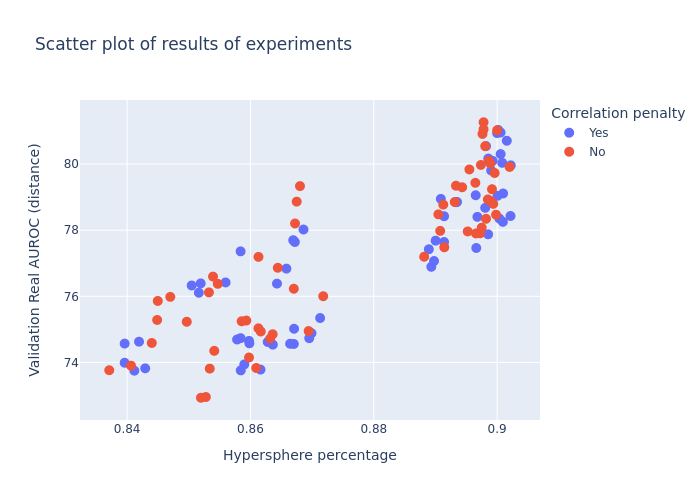

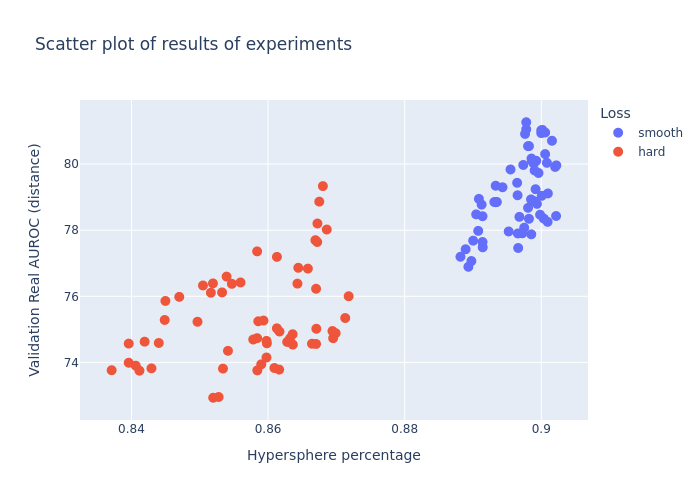

In [20]:
for labels_columns in df.columns[:5]:
    scatter_results(
        df,
        x=('val_hypersphere_percentage', 'mean'),
        y=('val_real_auroc', 'mean'),
        x_label='Hypersphere percentage',
        y_label='Validation Real AUROC (distance)',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

## Accuracy vs Real AUROC

In [21]:
np.corrcoef(
    df[('val_accuracy', 'mean')],
    df[('val_real_auroc', 'mean')],
)

array([[1.        , 0.62718688],
       [0.62718688, 1.        ]])

In [22]:
np.corrcoef(
    df[('val_accuracy', 'mean')],
    df[('val_max_val_auroc', 'mean')],
)

array([[ 1.        , -0.68003663],
       [-0.68003663,  1.        ]])

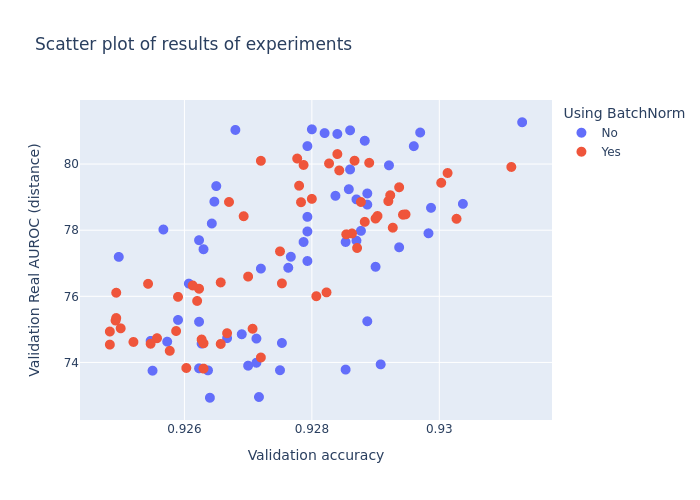

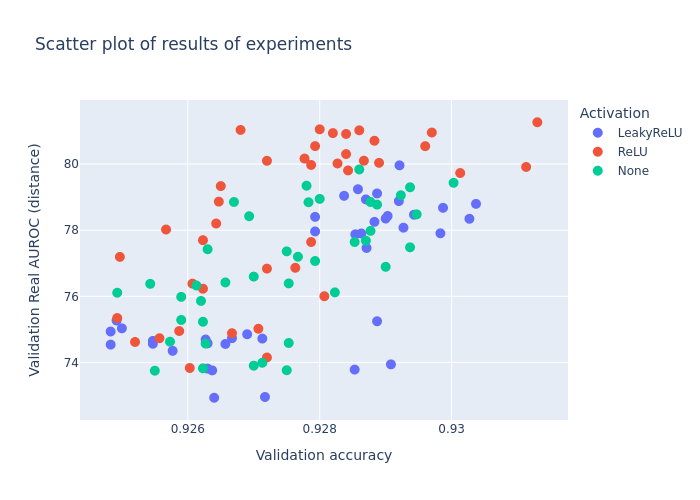

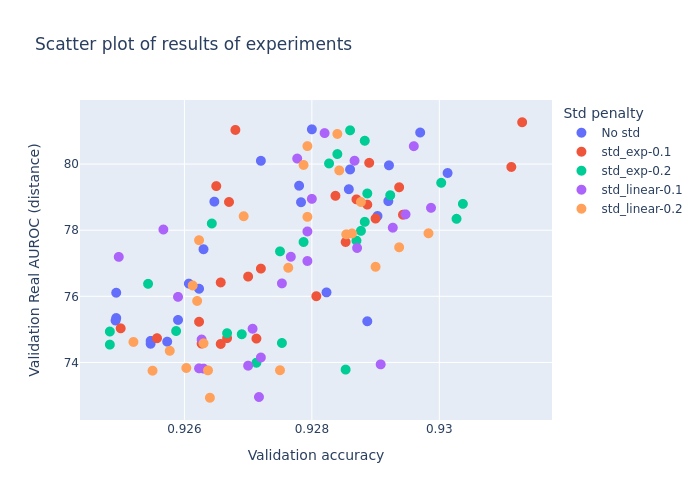

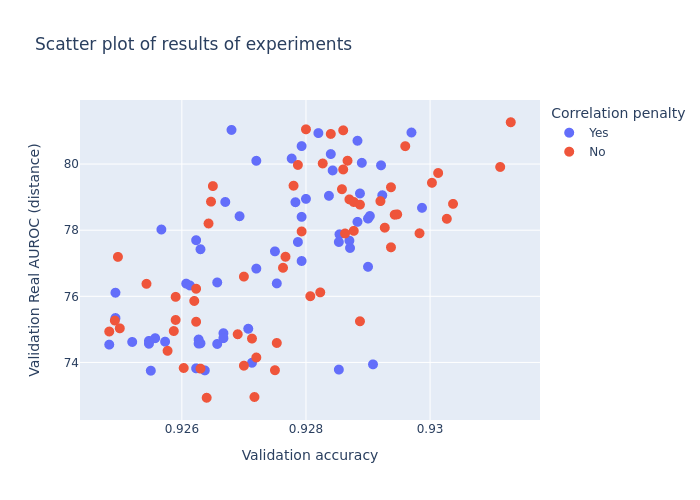

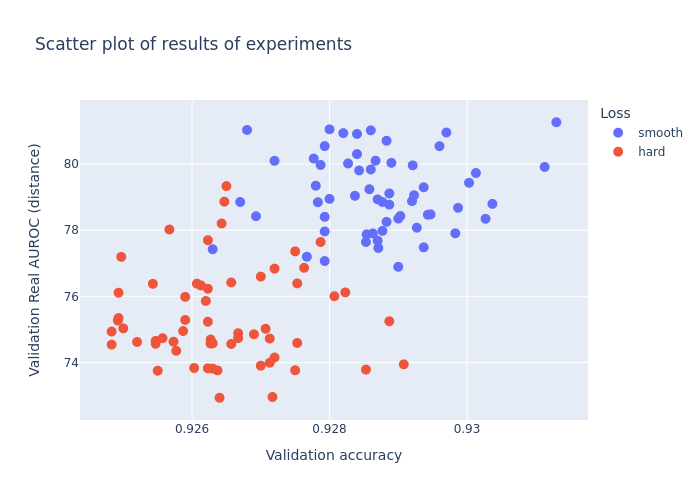

In [23]:
for labels_columns in df.columns[:5]:
    scatter_results(
        df,
        x=('val_accuracy', 'mean'),
        y=('val_real_auroc', 'mean'),
        x_label='Validation accuracy',
        y_label='Validation Real AUROC (distance)',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

## Accuracy vs weights correlation

In [24]:
np.corrcoef(
    df[('val_accuracy', 'mean')],
    df[('mean_weights_corr', 'mean')],
)

array([[1.        , 0.12184851],
       [0.12184851, 1.        ]])

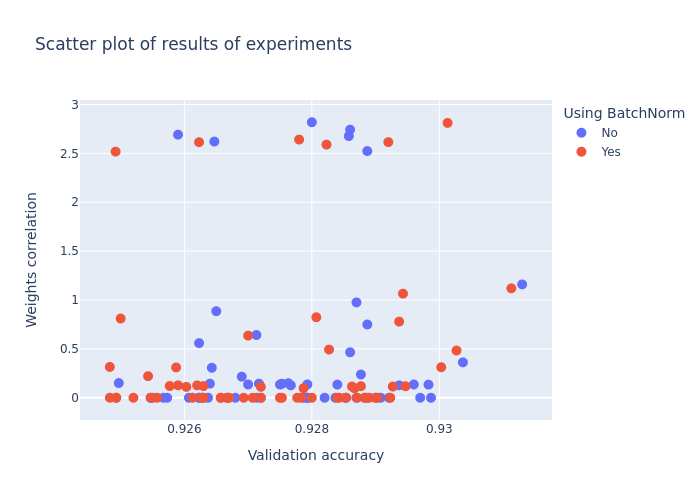

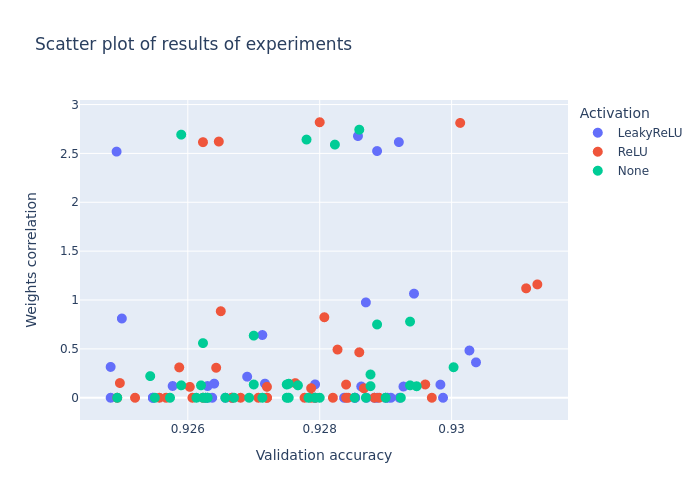

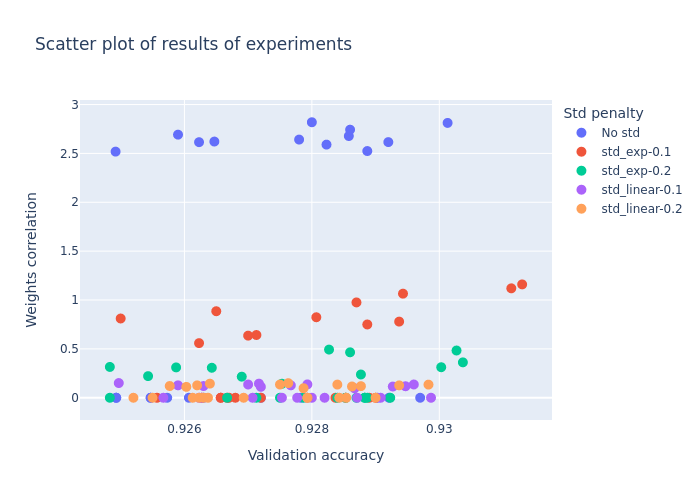

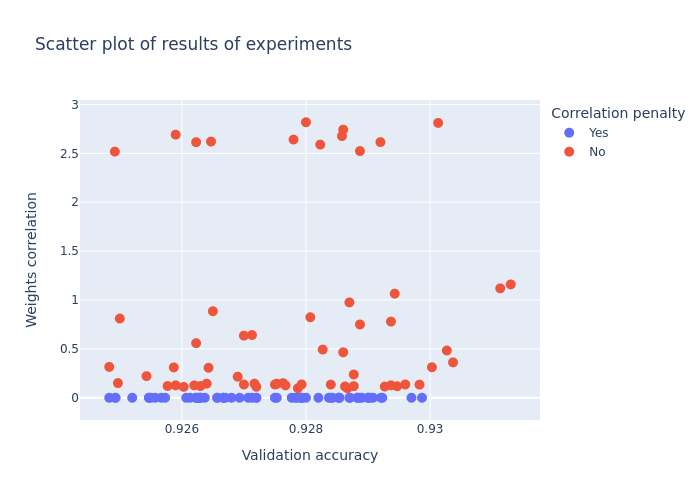

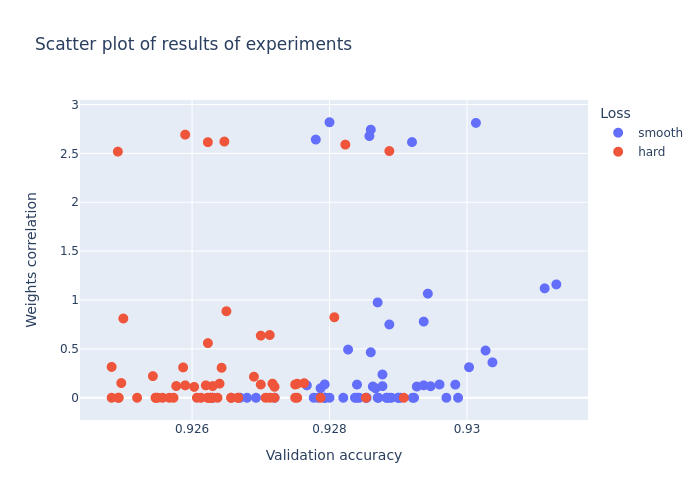

In [25]:
for labels_columns in df.columns[:5]:
    scatter_results(
        df,
        x=('val_accuracy', 'mean'),
        y=('mean_weights_corr', 'mean'),
        x_label='Validation accuracy',
        y_label='Weights correlation',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

## Accuracy vs weights std

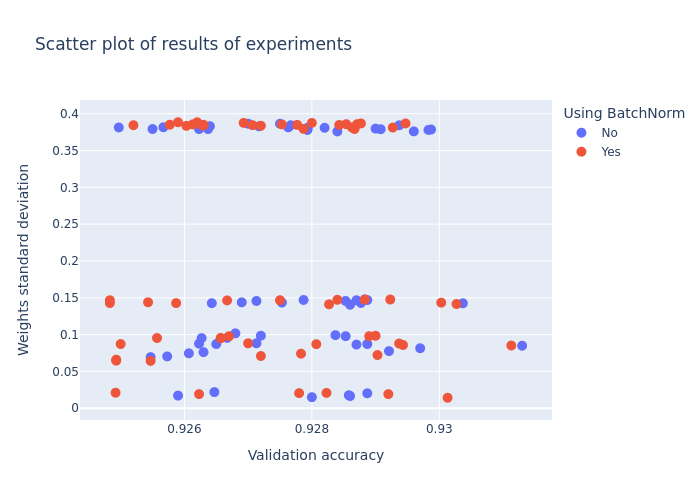

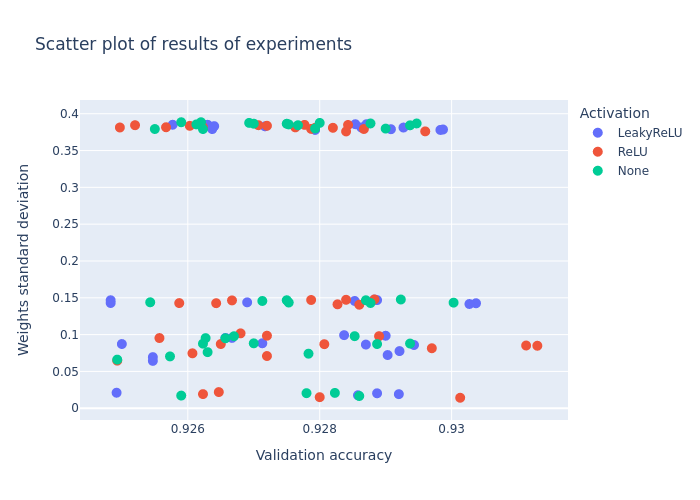

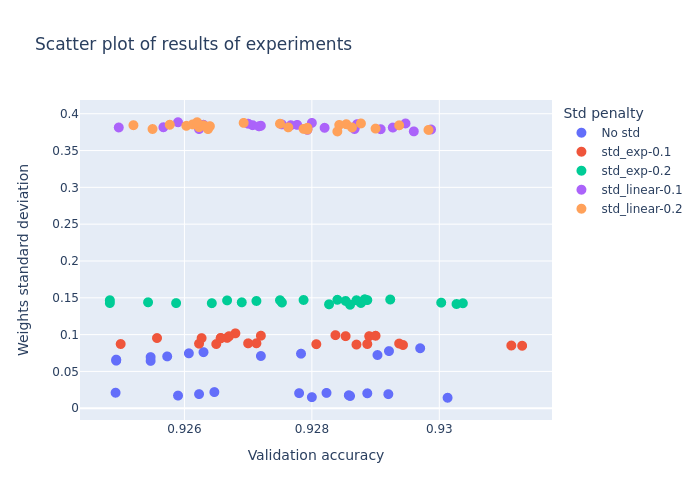

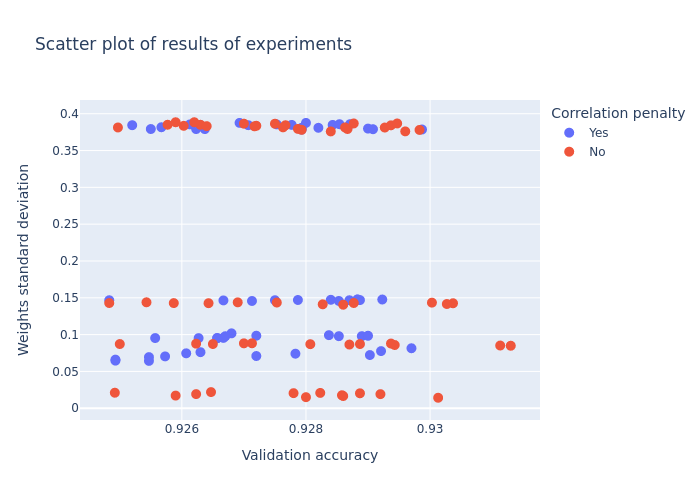

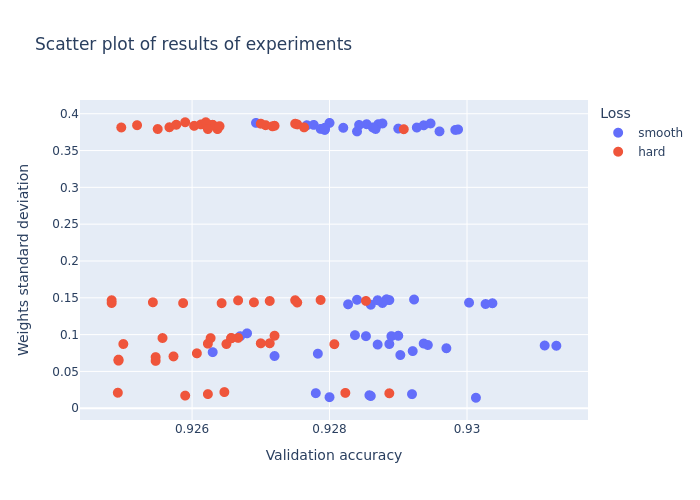

In [26]:
for labels_columns in df.columns[:5]:
    scatter_results(
        df,
        x=('val_accuracy', 'mean'),
        y=('mean_weights_std', 'mean'),
        x_label='Validation accuracy',
        y_label='Weights standard deviation',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

## Real AUROC vs weights std

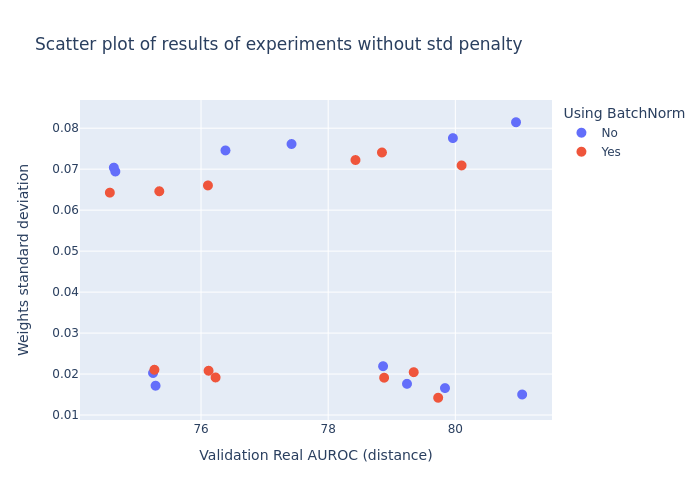

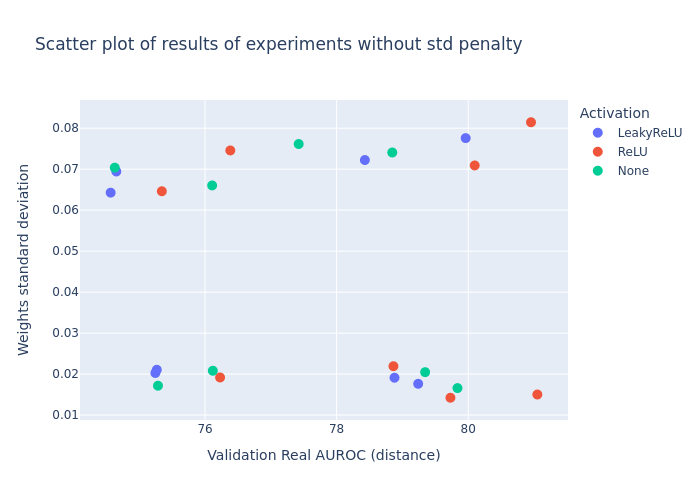

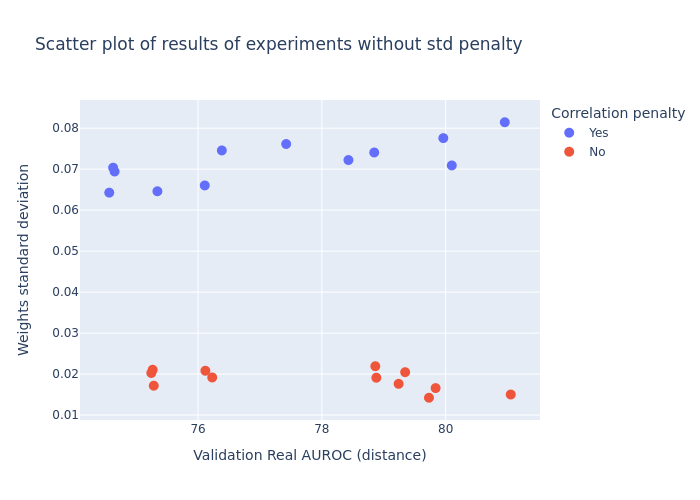

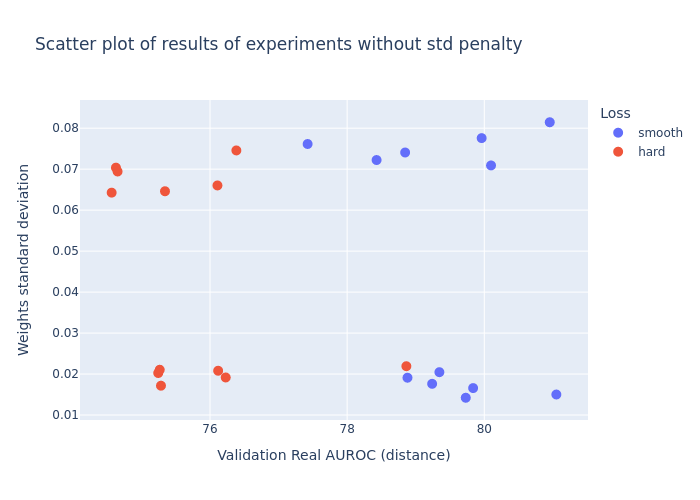

In [27]:
df_no_std = df[df[("Std penalty", "")] == "No std"]
for labels_columns in df.columns[:5]:
    if labels_columns[0] == "Std penalty":
        continue
    scatter_results(
        df_no_std,
        x=('val_real_auroc', 'mean'),
        y=('mean_weights_std', 'mean'),
        x_label='Validation Real AUROC (distance)',
        y_label='Weights standard deviation',
        title='Scatter plot of results of experiments without std penalty',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

In [28]:
for val in df[("Std penalty", "")].unique():
    print("Std penalty:", val)
    
    df_no_std = df[df[("Std penalty", "")] == val]

    a = np.corrcoef(
        df_no_std[('val_accuracy', 'mean')],
        df_no_std[('mean_weights_std', 'mean')],
    )
    print("\tCorrelation between val_accuracy and mean_weights_std", a[0, 1])

    b = np.corrcoef(
        df_no_std[('val_real_auroc', 'mean')],
        df_no_std[('mean_weights_std', 'mean')],
    )
    print("\tCorrelation between val_real_auroc and mean_weights_std", b[0, 1])

Std penalty: No std
	Correlation between val_accuracy and mean_weights_std -0.22196239852698943
	Correlation between val_real_auroc and mean_weights_std -0.095547902066484
Std penalty: std_exp-0.1
	Correlation between val_accuracy and mean_weights_std -0.31154186714475457
	Correlation between val_real_auroc and mean_weights_std -0.02888535439297157
Std penalty: std_exp-0.2
	Correlation between val_accuracy and mean_weights_std -0.0012628241348111326
	Correlation between val_real_auroc and mean_weights_std -0.05895641201784052
Std penalty: std_linear-0.1
	Correlation between val_accuracy and mean_weights_std -0.3186625186993298
	Correlation between val_real_auroc and mean_weights_std -0.2501438311101782
Std penalty: std_linear-0.2
	Correlation between val_accuracy and mean_weights_std -0.26300830470392117
	Correlation between val_real_auroc and mean_weights_std -0.25093402500705725


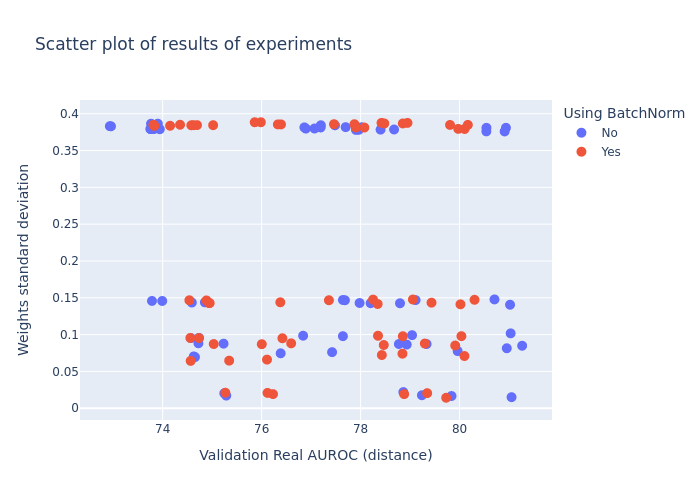

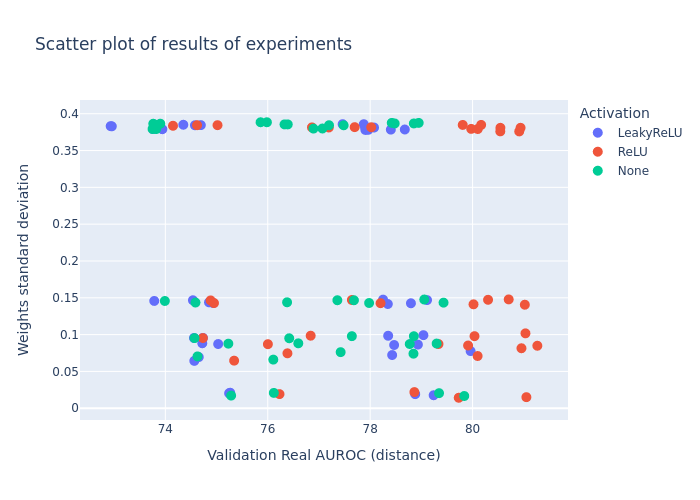

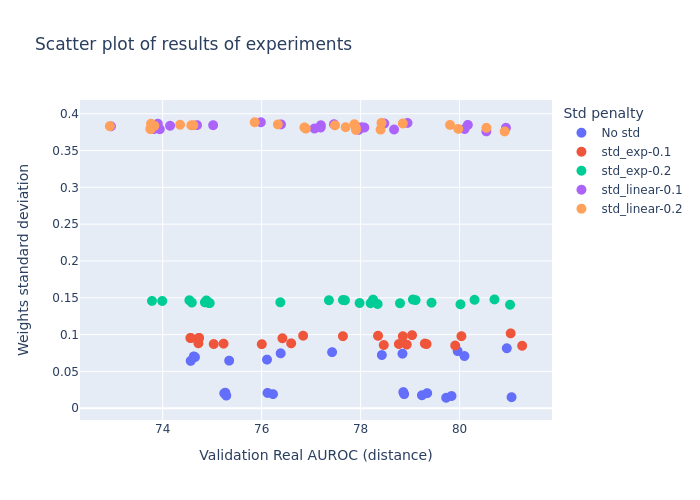

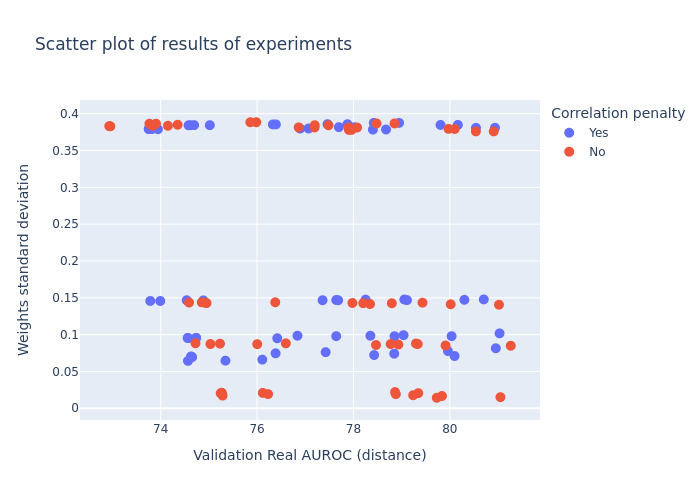

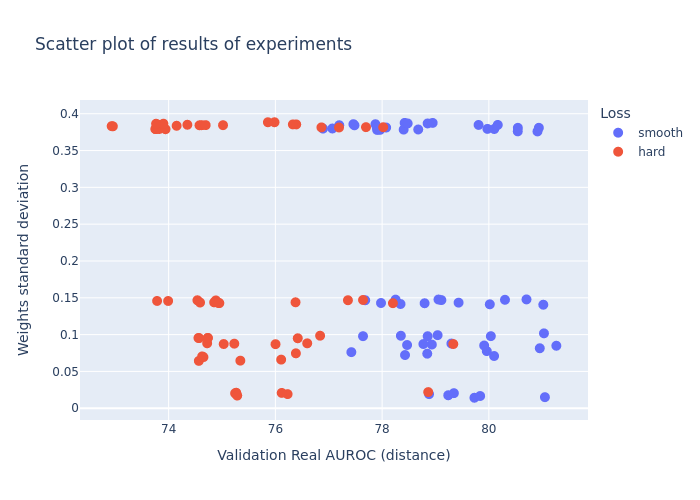

In [29]:
for labels_columns in df.columns[:5]:
    scatter_results(
        df,
        x=('val_real_auroc', 'mean'),
        y=('mean_weights_std', 'mean'),
        x_label='Validation Real AUROC (distance)',
        y_label='Weights standard deviation',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

## Real AUROC vs weights correlation

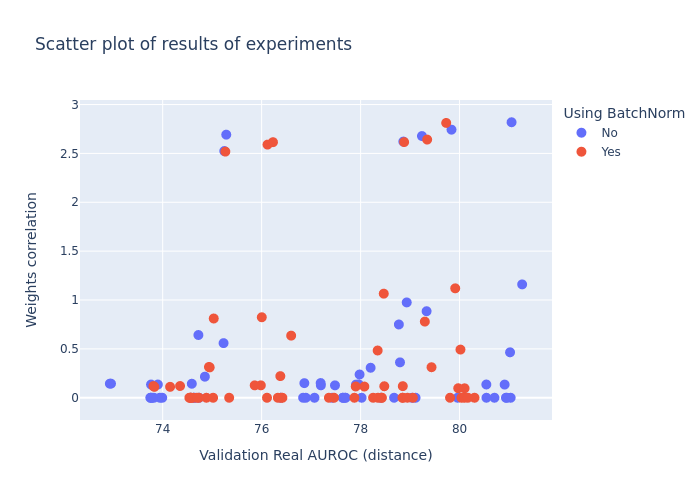

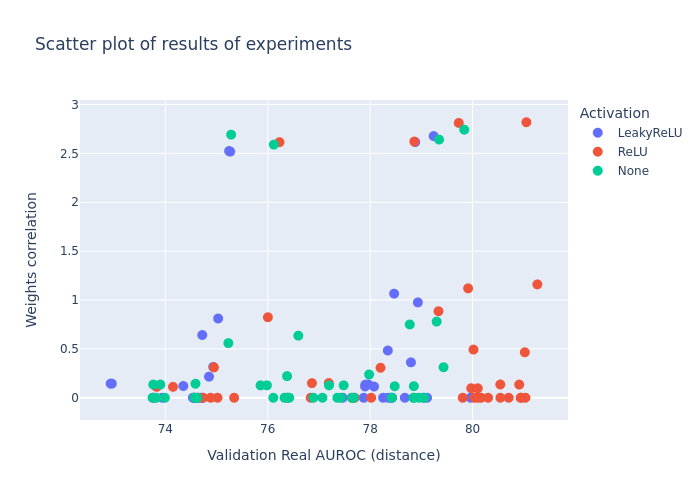

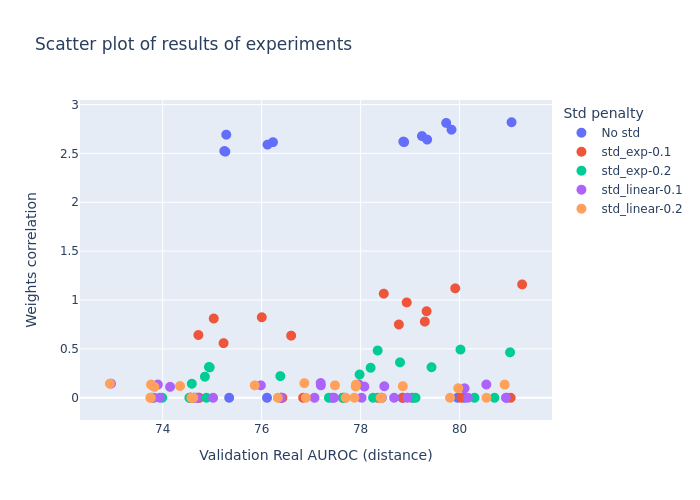

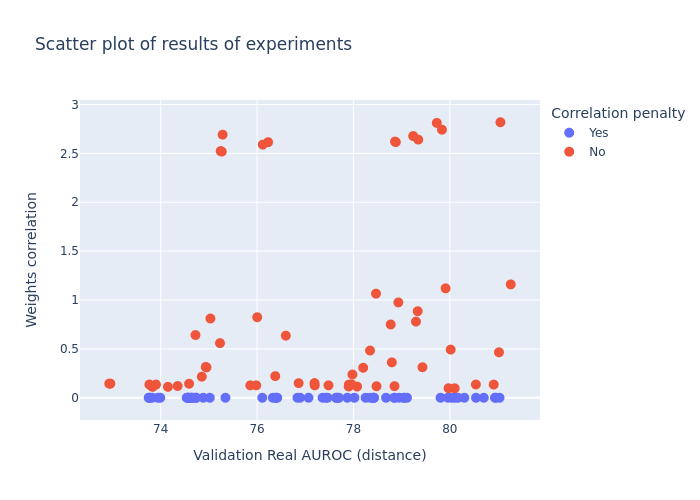

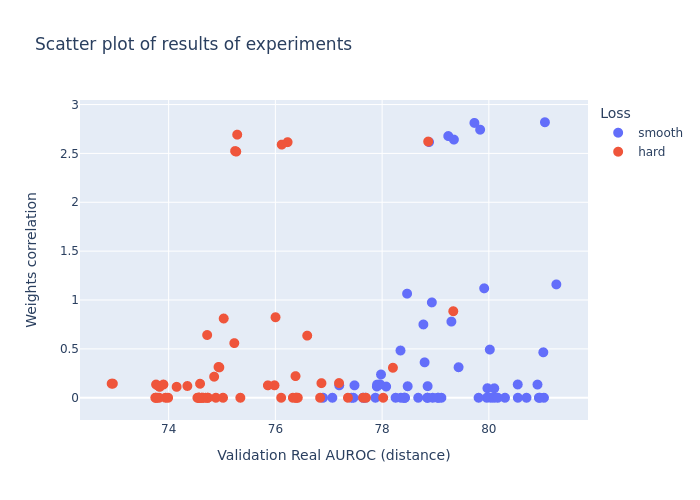

In [30]:
for labels_columns in df.columns[:5]:
    scatter_results(
        df,
        x=('val_real_auroc', 'mean'),
        y=('mean_weights_corr', 'mean'),
        x_label='Validation Real AUROC (distance)',
        y_label='Weights correlation',
        title='Scatter plot of results of experiments',
        labels_column=labels_columns,
        legend_title=labels_columns[0]
    )

# Additionnal graphs

In [31]:
results_dict_series = {}
for config, results in repetition_dict.items():
    results_dict_series[config] = {}
    # for k, v in results.items():
    #     results_dict_series[config][k] = {
    #         "mean": np.mean(v),
    #         "std": np.std(v),
    #     }
    for k, v in results.items():        
        if k == "mean_weights_std":
            results_dict_series[config][(k, "mean")] = np.mean(np.mean(v, axis=2), axis=0)
            results_dict_series[config][(k, "std")] = np.std(np.mean(v, axis=2), axis=0)
        else:
            results_dict_series[config][(k, "mean")] = np.mean(v, axis=0)
            results_dict_series[config][(k, "std")] = np.std(v, axis=0)

In [32]:
# split config in multiple columns
final_dict_series = {}
index_2_values_series = {}
columns = ["Using BatchNorm", "Activation", "Std penalty", "Correlation penalty", "Loss"]
# columns = ["Activation", "Std penalty", "Correlation penalty", "Loss"]


final_dict_series[("idx", "")] = []
for i in columns:
    final_dict_series[(i, '')] = []

for idx, (config, results) in enumerate(results_dict_series.items()):
    index_2_values_series[idx] = results
    params = config.split('/')
    converted_params = []
    converted_params.append("Yes" if "without" not in params[0] else "No")
    converted_params.append({"with_act": "ReLU", "without_act": "None", "with_act_leaky": "LeakyReLU"}[params[1]])
    converted_params.append("No std" if "without" in params[2] else params[2])
    converted_params.append("Yes" if "without" not in params[3] else "No")
    converted_params.append(params[4].split('_')[0])
    # print(converted_params)
    
    final_dict_series[("idx", "")].append(idx)
    # final_dict_series[tuple(converted_params)] = {}
    
    for i, p in enumerate(converted_params):
        final_dict_series[(columns[i], '')].append(p)
    
    # for k, v in results.items():
    #     final_dict_series[tuple(converted_params)].setdefault(k, []).append(v)
    

In [33]:
final_dict_series.keys()

dict_keys([('idx', ''), ('Using BatchNorm', ''), ('Activation', ''), ('Std penalty', ''), ('Correlation penalty', ''), ('Loss', '')])

In [34]:
config_df = pd.DataFrame(final_dict_series).set_index("idx")
config_df

,Using BatchNorm,Activation,Std penalty,Correlation penalty,Loss
,,,,,
idx,,,,,
0,No,None,std_exp-0.2,No,hard
1,No,None,std_exp-0.2,No,smooth
2,No,None,std_exp-0.2,Yes,hard
3,No,None,std_exp-0.2,Yes,smooth
4,No,None,No std,No,hard
...,...,...,...,...,...
115,Yes,LeakyReLU,std_linear-0.2,Yes,smooth
116,Yes,LeakyReLU,std_linear-0.1,No,hard


In [35]:
index_2_values_series[0].keys()

dict_keys([('accuracy', 'mean'), ('accuracy', 'std'), ('val_accuracy', 'mean'), ('val_accuracy', 'std'), ('test_accuracy', 'mean'), ('test_accuracy', 'std'), ('loss', 'mean'), ('loss', 'std'), ('model_losses', 'mean'), ('model_losses', 'std'), ('mean_weights_std', 'mean'), ('mean_weights_std', 'std'), ('mean_weights_corr', 'mean'), ('mean_weights_corr', 'std'), ('weights_sample', 'mean'), ('weights_sample', 'std'), ('val_loss', 'mean'), ('val_loss', 'std'), ('val_real_auroc', 'mean'), ('val_real_auroc', 'std'), ('val_max_val_auroc', 'mean'), ('val_max_val_auroc', 'std'), ('val_oscr', 'mean'), ('val_oscr', 'std'), ('test_loss', 'mean'), ('test_loss', 'std'), ('test_real_auroc', 'mean'), ('test_real_auroc', 'std'), ('test_max_val_auroc', 'mean'), ('test_max_val_auroc', 'std'), ('test_oscr', 'mean'), ('test_oscr', 'std'), ('val_hypersphere_percentage', 'mean'), ('val_hypersphere_percentage', 'std')])

In [36]:
def get_index_from_config(bn=None, act=None, std=None, corr=None, loss=None):
    loc = config_df[
        (True if not bn else config_df[("Using BatchNorm", "")] == bn) &
        (True if not act else config_df[("Activation", "")] == act) &
        (True if not std else config_df[("Std penalty", "")] == std) &
        (True if not corr else config_df[("Correlation penalty", "")] == corr) &
        (True if not loss else config_df[("Loss", "")] == loss)
    ].index
    
    return list(loc)

In [37]:
def get_values(index, key):
    res = []
    for i in sorted(index):
        res.append(index_2_values_series[i][key])
    return res

In [38]:
def rows_from_index(index):
    return config_df.iloc[index]

In [39]:
def get_possible_values():
    for i in config_df.columns:
        print(i, config_df[i].unique())
get_possible_values()

('Using BatchNorm', '') ['No' 'Yes']
('Activation', '') ['None' 'ReLU' 'LeakyReLU']
('Std penalty', '') ['std_exp-0.2' 'No std' 'std_exp-0.1' 'std_linear-0.2' 'std_linear-0.1']
('Correlation penalty', '') ['No' 'Yes']
('Loss', '') ['hard' 'smooth']


In [40]:
indices = get_index_from_config(
    act="ReLU",
    std="No std",
)
indices

[24, 25, 26, 27, 84, 85, 86, 87]

In [41]:
data = np.array(get_values(indices, ('mean_weights_std', 'mean')))

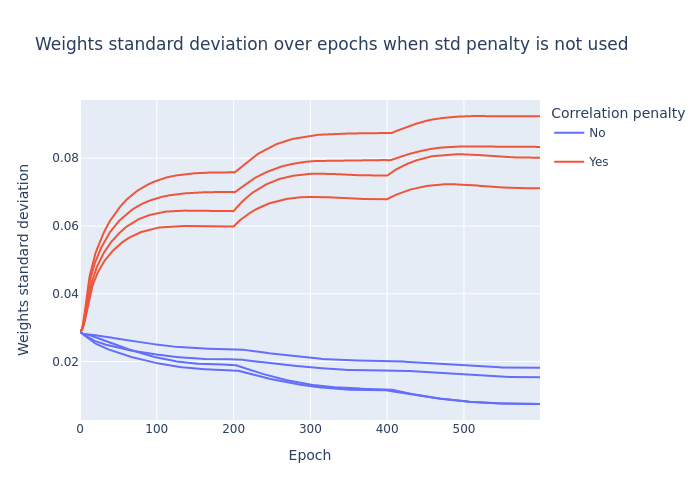

In [42]:
fig = go.Figure()

labels_column = ("Correlation penalty", "")

sub_df = config_df.loc[indices]

from plotly import colors as plotly_colors

colors = plotly_colors.qualitative.Plotly

for i, label in enumerate(sub_df[labels_column].unique()):
    class_df=sub_df[sub_df[labels_column] == label]
    
    data = np.array(get_values(class_df.index, ('mean_weights_std', 'mean')))
    
    for idx, d in enumerate(data):
        # Add hover text        
        hover_text = (
            "Idx: {idx}<br>Using BatchNorm: {bn}<br>Activation: {lr}<br>Std penalty: {std}<br>Correlation penalty: {corr}<br>Loss: {loss}".format(
                idx = class_df.index[idx],
                bn = class_df.iloc[idx, 0],
                lr = class_df.iloc[idx, 1],
                std = class_df.iloc[idx, 2],
                corr = class_df.iloc[idx, 3],
                loss = class_df.iloc[idx, 4],
            )
        )
        
        fig.add_trace(
            go.Scatter(
                x=np.arange(0, data.shape[1]),
                y=d,
                mode='lines',
                marker=dict(
                    size=10,
                    color=colors[i],
                ),
                name=label,
                legendgroup=label,
                showlegend=True if idx == 0 else False,
                text=hover_text,
                hoverinfo="text"
            )
        )
    
    # Change legend title
    fig.update_layout(
        legend_title=labels_column[0],
    )

    # Update layout
    fig.update_layout(
        title="Weights standard deviation over epochs when std penalty is not used",
        xaxis_title="Epoch",
        yaxis_title="Weights standard deviation",
    )
    
fig.show()


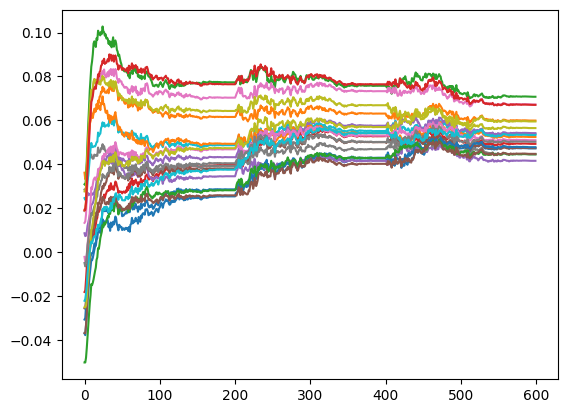

In [43]:
indices = get_index_from_config(
    act="ReLU",
    std="No std",
)

data = get_values(indices, ('weights_sample', 'mean'))

j = indices.index(24)
plt.plot(data[j][:,:20])
plt.show()

Using BatchNorm              No
Activation                 ReLU
Std penalty              No std
Correlation penalty         Yes
Loss                     smooth
Name: 27, dtype: object
Max correlation: 0.15453990331060405


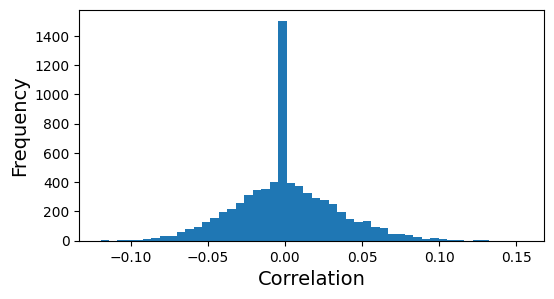

Correlation: -0.1497018724163497
Weights difference: 0.11851587


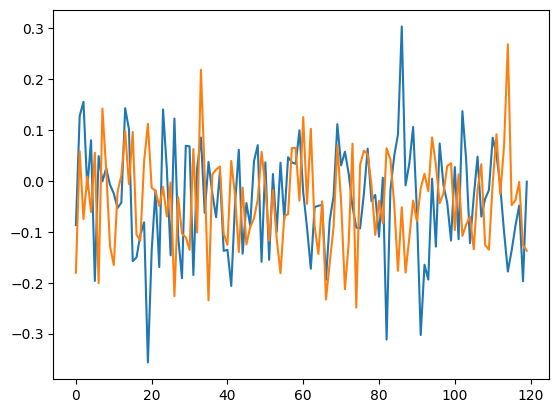

In [44]:
def check_real_weights(exp_index, run_idx=0):
    config = config_df.loc[exp_index]
    print(config)
    
    real_file = os.path.join(
        RES_DIR, 
        { "Yes": "with_bn", "No": "without_bn" }[config[("Using BatchNorm", "")]],
        { "ReLU": "with_act", "None": "without_act", "LeakyReLU": "with_act_leaky" }[config[("Activation", "")]],
        { "No std": "without_std", "Yes": "with_std" }[config[("Std penalty", "")]],
        { "No": "without_corr", "Yes": "with_corr" }[config[("Correlation penalty", "")]],
        { "smooth": "smooth_loss", "hard": "hard_loss" }[config[("Loss", "")]],
        ""
    )
    
    model = tf.keras.models.load_model(os.path.join(real_file, f"run_{run_idx}_model.save"))
        
    weights = model.get_layer("last_conv").get_weights()[0]
    weights = weights.reshape(-1, weights.shape[-1])
    
    corr_matrix = np.corrcoef(weights, rowvar=False)
    print("Max correlation:", np.max(corr_matrix-np.eye(corr_matrix.shape[0])))
    
    # Correlation distribution
    plt.figure(figsize=(6, 3))
    plt.hist(corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)], bins=50)
    # plt.title("Correlation distribution of weights of last convolutional layer")
    plt.xlabel("Correlation", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)    
    plt.savefig('results/figures/image_vision_computing/weights_correlation_histogram_difair.pdf', bbox_inches='tight')
    plt.show()
    
    print("Correlation:", np.corrcoef(weights[0], weights[1])[0, 1])
    print("Weights difference:", np.mean(np.abs(weights[0] - weights[1])))
        
    # plt.plot(weights[0], weights[1], 'o')
    plt.plot(weights[0])
    plt.plot(weights[1])
    plt.show()
    
check_real_weights(27)

Using BatchNorm              No
Activation                 ReLU
Std penalty              No std
Correlation penalty          No
Loss                       hard
Name: 24, dtype: object
Max correlation: 0.9794594240665507


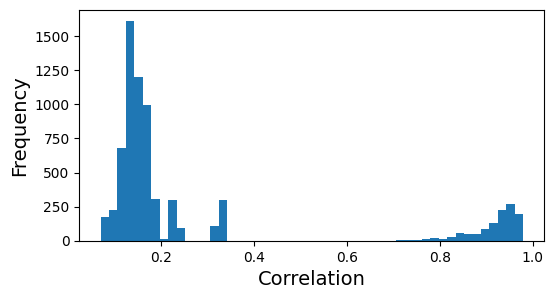

Correlation: -0.2838259337598832
Weights difference: 0.090673834


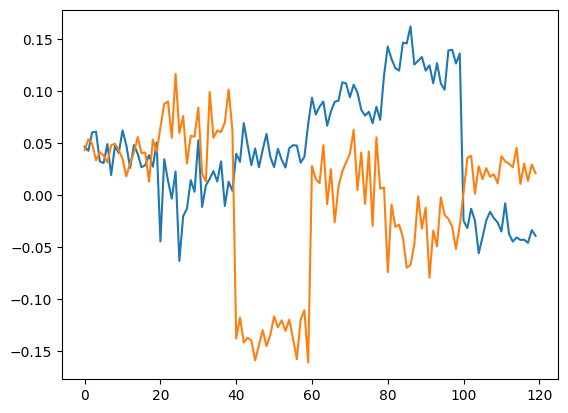

In [45]:
check_real_weights(24)

Max correlation: 0.7716490850305965


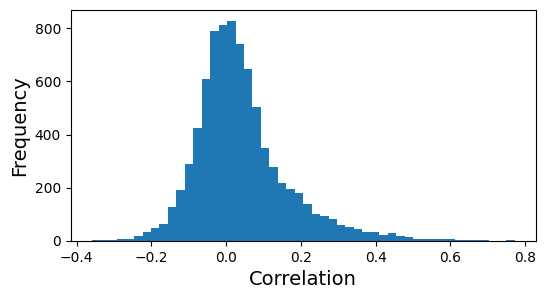

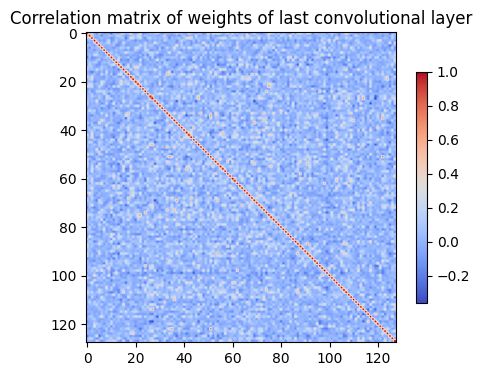

Correlation: 0.0949283317385107
Weights difference: 0.096297815


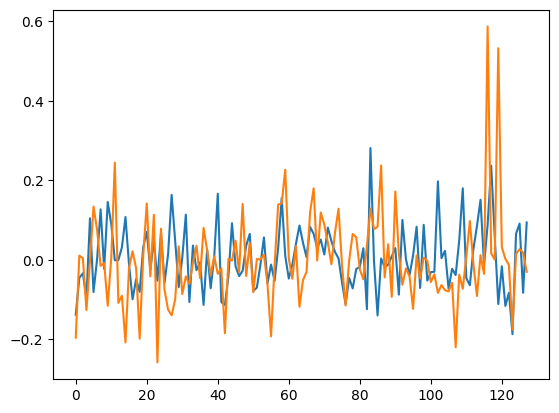

In [46]:
crossentropy_path = "results/benchmark_osr_v3/crossentropy/cifar10/"

possible_models = list_final_dirs(crossentropy_path)

def check_crossentropy_weights(idx, run_idx=0):    
    real_file = possible_models[idx].replace("flags.txt", "model.save")
    model = tf.keras.models.load_model(real_file)
    
    # get last conv layer
    weights = None
    for layer in model.layers[::-1]:
        if "conv" in layer.name:
            weights = layer.get_weights()[0]
            break
    weights = weights.reshape(-1, weights.shape[-1])
    
    corr_matrix = np.corrcoef(weights, rowvar=False)
    print("Max correlation:", np.max(corr_matrix-np.eye(corr_matrix.shape[0])))
    
    # Correlation distribution
    plt.figure(figsize=(6, 3))
    plt.hist(corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)], bins=50)
    # plt.title("Correlation distribution of weights of last convolutional layer")
    plt.xlabel("Correlation", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.savefig('results/figures/image_vision_computing/weights_correlation_histogram_crossentropy.pdf', bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(corr_matrix, cmap="coolwarm")
    plt.title("Correlation matrix of weights of last convolutional layer")
    plt.colorbar(shrink=0.6)
    plt.show()
    
    print("Correlation:", np.corrcoef(weights[0], weights[1])[0, 1])
    print("Weights difference:", np.mean(np.abs(weights[0] - weights[1])))
        
    plt.plot(weights[0])
    plt.plot(weights[1])
    plt.show()
    
check_crossentropy_weights(1)

In [47]:
config_df.loc[24]

Using BatchNorm              No
Activation                 ReLU
Std penalty              No std
Correlation penalty          No
Loss                       hard
Name: 24, dtype: object

In [48]:
with open("results/loss_configurations_search/without_bn/with_act/without_std/without_corr/smooth_loss/run_0_history.pkl", "rb") as f:
    history = pickle.load(f)    
    
history.keys()

dict_keys(['accuracy', 'val_accuracy', 'test_accuracy', 'loss', 'model_losses', 'mean_weights_std', 'mean_weights_corr', 'weights_sample', 'val_loss', 'val_real_auroc', 'val_max_val_auroc', 'val_oscr', 'test_loss', 'test_real_auroc', 'test_max_val_auroc', 'test_oscr', 'val_hypersphere_percentage'])

In [49]:
np.array(history['weights_sample']).shape

(600, 120)

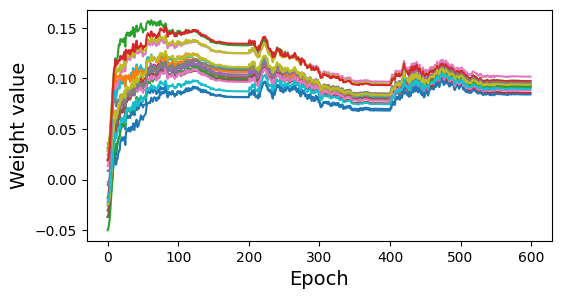

In [50]:
plt.figure(figsize=(6, 3))
plt.plot(np.array(history['weights_sample'])[:, :20])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Weight value', fontsize=14)
plt.savefig('results/figures/image_vision_computing/no_penalty_weights.pdf', bbox_inches='tight')
plt.show()

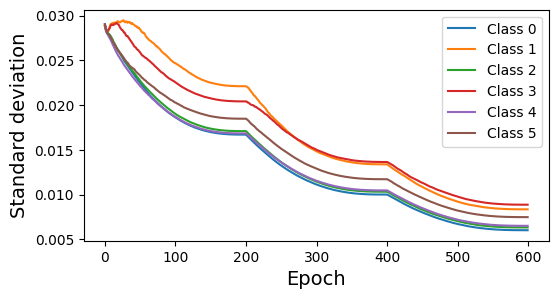

In [51]:
plt.figure(figsize=(6, 3))
plt.plot(np.array(history['mean_weights_std']), label=[f"Class {i}" for i in range(6)])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Standard deviation', fontsize=14)
plt.legend()
plt.savefig('results/figures/image_vision_computing/no_penalty_std.pdf', bbox_inches='tight')
plt.show()